In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# Setting up the working directory
import os

WORK_DIR = '/content/drive/MyDrive/WasAdvGAN/mnist'
os.chdir(WORK_DIR)
print(os.listdir('./'))

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
print(os.listdir(DATA_DIR))

MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)
print(os.listdir(MODEL_DIR))

PLOT_DIR = 'plots'
os.makedirs(PLOT_DIR, exist_ok=True)
print(os.listdir(PLOT_DIR))

# PGD_DIR = 'advgan'
# os.makedirs(ADVGAN_DIR, exist_ok=True)
# print(os.listdir(ADVGAN_DIR))

ADV_DATA_DIR = 'data/advgan'
os.makedirs(ADV_DATA_DIR, exist_ok=True)
print(os.listdir(ADV_DATA_DIR))

WAGAN_DATA_DIR = 'data/wagan'
os.makedirs(WAGAN_DATA_DIR, exist_ok=True)
print(os.listdir(WAGAN_DATA_DIR))

PGD_DATA_DIR = 'data/pgd'
os.makedirs(PGD_DATA_DIR, exist_ok=True)
print(os.listdir(PGD_DATA_DIR))

['models.py', 'data', '__pycache__', 'saved_models', 'plots', 'advgan', 'wagan', 'advgan.py', 'pipeline.py', 'wasserstein.py', 'AdvGAN.ipynb', 'wagan.py', 'WAGAN-beta_plus.ipynb', 'WAGAN-beta_zero.ipynb', 'WAGAN-beta_minus.ipynb', 'Training.ipynb', 'Testing.ipynb', 'PGD.ipynb']
['MNIST', 'advgan', 'wagan', 'pgd']
['model_original.pth', 'config_original.json', 'model_advgan_original.pth', 'config_advgan_original.json', 'config_wagan_beta_plus.json', 'model_wagan_beta_plus.pth', 'model_wagan_beta_minus.pth', 'config_wagan_beta_minus.json', 'model_wagan_beta_zero.pth', 'config_wagan_beta_zero.json', 'model_pgd_robust.pth', 'config_pgd_robust.json']
['training_error_original.png', 'training_error_pgd_robust.png']
['adv_test_images_original.pickle', 'test_labels_original.pickle', 'adv_train_images_original.pickle', 'train_labels_original.pickle']
['adv_train_images_beta_plus.pickle', 'train_labels_beta_plus.pickle', 'adv_test_images_beta_plus.pickle', 'test_labels_beta_plus.pickle', 'adv_tr

In [41]:
from tqdm.autonotebook import tqdm
import itertools

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch
import numpy as np
import models
import torch.nn.functional as F
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from pipeline import TargetModel_Pipeline

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [43]:
class PGD_Attack:
    def __init__(self, config):
      self.device = config["device"]
      self.model = models.MNIST_target_net().to(self.device)
      self.model.load_state_dict(torch.load(config["trained_model"]))
      self.model.eval()
      self.epsilon = config["epsilon"]
      self.learning_rate = config["learning_rate"]
      self.max_iter = config["max_iter"]
      self.box_min = config["box_min"]
      self.box_max = config["box_max"]
      self.criterion = nn.CrossEntropyLoss()

    def __call__(self, image, label):
        for iter in tqdm(list(range(self.max_iter)), leave = False):
            image.requires_grad = True    
            outputs = self.model(image)

            self.model.zero_grad()
            loss = self.criterion(outputs, label).to(self.device)
            loss.backward()

            adv_image = image + self.learning_rate * image.grad.sign()
            adv_noise = torch.clamp(adv_image - image, min = -self.epsilon, max = self.epsilon)
            image = torch.clamp(image + adv_noise, min = self.box_min, max = self.box_max).detach_()

        return image

    def calc_adverserial_acc(self, dataloader):
        num_correct_orig, num_correct_adv = 0, 0
        for image, label in tqdm(dataloader):
          image, label = image.to(self.device), label.to(self.device)
          adv_image = self(image, label).to(self.device)
          pred_lab_orig = torch.argmax(self.model(image), 1)
          num_correct_orig += torch.sum(pred_lab_orig == label, 0)
          pred_lab_adv = torch.argmax(self.model(adv_image), 1)
          num_correct_adv += torch.sum(pred_lab_adv == label, 0)

        return num_correct_orig.item(), num_correct_adv.item()
    
    def convert(self, dataloader):
        images = []
        labels = []
        for image, label in tqdm(dataloader):
            image = image.to(self.device)
            label = label.to(self.device)

            for iter in tqdm(list(range(self.max_iter)), leave = False):
                image.requires_grad = True    
                outputs = self.model(image)

                self.model.zero_grad()
                loss = self.criterion(outputs, label).to(self.device)
                loss.backward()

                adversarial_image = image + self.learning_rate * image.grad.sign()
                adversarial_noise = torch.clamp(adversarial_image - image, min = -self.epsilon, max = self.epsilon)
                image = torch.clamp(image + adversarial_noise, min = self.box_min, max = self.box_max).detach_()
            
            images.append(image)
            labels.append(label)
        
        images = torch.cat(images)
        labels = torch.cat(labels)
    
        return list(zip(images, labels))

In [74]:
config = dict()
config["device"] = device
config["trained_model"] = MODEL_DIR + '/model_original.pth'
config["epsilon"] = 0.001
config["learning_rate"] = 2/255
config["max_iter"] = 200
config["box_min"] = 0
config["box_max"] = 1
config["batch_size"] = 1024

In [75]:
pgd = PGD_Attack(config)

In [76]:
mnist_train_dataset = torchvision.datasets.MNIST(DATA_DIR, train = True, download = False, transform = transforms.ToTensor())
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size = config["batch_size"], shuffle = False)

In [77]:
mnist_adv_train_dataset = pgd.convert(mnist_train_dataloader)

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [78]:
mnist_test_dataset = torchvision.datasets.MNIST(DATA_DIR, train = False, download = True, transform = transforms.ToTensor())
mnist_test_dataloader = DataLoader(mnist_test_dataset, batch_size = config["batch_size"], shuffle = False)

In [79]:
mnist_adv_test_dataset = pgd.convert(mnist_test_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## PGD robust Target Model

In [80]:
# Setting up training config
config = dict()
config['name'] = 'pgd_robust'
config['batch_size'] = 256
config['total_epochs'] = 50
config['cutoff_epoch'] = 20
config['early_learning_rate'] = 0.001
config['late_learning_rate'] = 0.0001

for key, value in config.items():
    print(key, ' : ', value)

name  :  pgd_robust
batch_size  :  256
total_epochs  :  50
cutoff_epoch  :  20
early_learning_rate  :  0.001
late_learning_rate  :  0.0001


In [81]:
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

In [82]:
mnist_adv_train_dataloader = DataLoader(mnist_adv_train_dataset, batch_size = config["batch_size"], shuffle = False)

In [83]:
# Training the model
loss_epochs = pipeline.fit(mnist_adv_train_dataloader)

  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 0: 123.473465


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 1: 38.901672


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 2: 17.205824


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 3: 10.247427


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 4: 7.465873


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 5: 5.673425


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 6: 5.255445


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 7: 4.048584


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 8: 3.411043


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 9: 3.510398


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 10: 3.415001


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 11: 3.183166


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 12: 2.429816


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 13: 2.234312


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 14: 1.703081


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 15: 2.049903


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 16: 2.218329


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 17: 1.780327


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 18: 1.176285


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 19: 1.428167


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 20: 0.786385


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 21: 0.425147


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 22: 0.352043


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 23: 0.263783


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 24: 0.255415


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 25: 0.288289


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 26: 0.154515


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 27: 0.162926


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 28: 0.153217


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 29: 0.178547


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 30: 0.163219


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 31: 0.162448


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 32: 0.176723


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 33: 0.203786


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 34: 0.136160


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 35: 0.142161


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 36: 0.158369


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 37: 0.118719


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 38: 0.116723


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 39: 0.104820


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 40: 0.058627


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 41: 0.153452


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 42: 0.120136


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 43: 0.091831


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 44: 0.165148


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 45: 0.139669


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 46: 0.079803


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 47: 0.067725


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 48: 0.074572


  0%|          | 0/235 [00:00<?, ?it/s]

loss in epoch 49: 0.096073


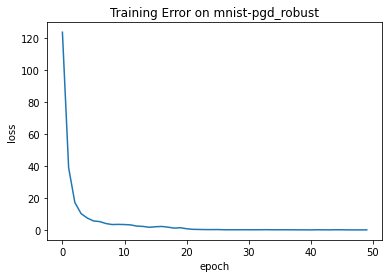

In [84]:
plt.plot(loss_epochs, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Error on mnist-'+str(config['name']))
plt.savefig(PLOT_DIR+'/training_error_'+str(config['name'])+ '.png')

In [85]:
# MNIST test dataset
mnist_adv_test_dataloader = DataLoader(mnist_adv_test_dataset, batch_size = config["batch_size"], shuffle = False)
# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(accuracy)

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.997000

0.997


## Examples of the adversarial images created

In [86]:
real_images_ex = None

for images, labels in mnist_train_dataloader:
  real_images_ex = images.detach().clone()
  print(real_images_ex.shape)
  break

torch.Size([1024, 1, 28, 28])


In [87]:
adverserial_images_ex = None

for images, labels in mnist_adv_train_dataloader:
  adverserial_images_ex = images.detach().clone()
  print(adverserial_images_ex.shape)
  break

torch.Size([256, 1, 28, 28])


torch.Size([28, 28])


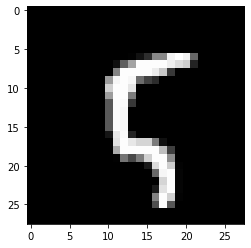

In [88]:
index = 100
real = torch.squeeze(real_images_ex[index])
print(real.shape)
plt.imshow(real.cpu().numpy().squeeze(), cmap='gray')
plt.show()

torch.Size([28, 28])


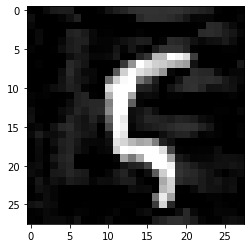

In [89]:
index = 100
adversary = torch.squeeze(adverserial_images_ex[index])
print(adversary.shape)
plt.imshow(adversary.cpu().numpy().squeeze(), cmap='gray')
plt.show()

## Testing on different test sets

In [90]:
# Original MNIST test dataset
mnist_test = torchvision.datasets.MNIST(DATA_DIR, train=False, transform=transforms.ToTensor(), download=False)
test_dataloader = DataLoader(mnist_test, batch_size=pipeline.config['batch_size'], shuffle=True, num_workers=1)
# Testing the model
accuracy = pipeline.eval(test_dataloader)
print(100*accuracy)

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.978200

97.82


In [91]:
advgan_config_name = 'original'
config['batch_size'] = 128

with open(ADV_DATA_DIR + '/adv_test_images_' + advgan_config_name + '.pickle', 'rb') as handle:
    adv_images_test = pickle.load(handle)

with open(ADV_DATA_DIR + '/test_labels_' + advgan_config_name + '.pickle', 'rb') as handle:
    real_labels_test = pickle.load(handle)

print(adv_images_test.shape)
print(real_labels_test.shape)

test_dataset = list(zip(adv_images_test, real_labels_test))
test_dataloader = None
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'])

# Testing the model
accuracy = pipeline.eval(test_dataloader)
print(100*accuracy)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


  0%|          | 0/79 [00:00<?, ?it/s]

accuracy in testing set: 0.958700

95.87


In [92]:
wagan_config_name = 'beta_zero'
config['batch_size'] = 128

with open(WAGAN_DATA_DIR + '/adv_test_images_' + wagan_config_name + '.pickle', 'rb') as handle:
    adv_images_test = pickle.load(handle)

with open(WAGAN_DATA_DIR + '/test_labels_' + wagan_config_name + '.pickle', 'rb') as handle:
    real_labels_test = pickle.load(handle)

print(adv_images_test.shape)
print(real_labels_test.shape)

test_dataset = list(zip(adv_images_test, real_labels_test))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'])

# Testing the model
accuracy = pipeline.eval(test_dataloader)
print(100*accuracy)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


  0%|          | 0/79 [00:00<?, ?it/s]

accuracy in testing set: 0.938800

93.88


In [103]:
wagan_config_name = 'beta_minus'
config['batch_size'] = 128

with open(WAGAN_DATA_DIR + '/adv_test_images_' + wagan_config_name + '.pickle', 'rb') as handle:
    adv_images_test = pickle.load(handle)

with open(WAGAN_DATA_DIR + '/test_labels_' + wagan_config_name + '.pickle', 'rb') as handle:
    real_labels_test = pickle.load(handle)

print(adv_images_test.shape)
print(real_labels_test.shape)

test_dataset = list(zip(adv_images_test, real_labels_test))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'])

# Testing the model
accuracy = pipeline.eval(test_dataloader)
print(100*accuracy)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


  0%|          | 0/79 [00:00<?, ?it/s]

accuracy in testing set: 0.936500

93.65


In [94]:
wagan_config_name = 'beta_plus'
config['batch_size'] = 128

with open(WAGAN_DATA_DIR + '/adv_test_images_' + wagan_config_name + '.pickle', 'rb') as handle:
    adv_images_test = pickle.load(handle)

with open(WAGAN_DATA_DIR + '/test_labels_' + wagan_config_name + '.pickle', 'rb') as handle:
    real_labels_test = pickle.load(handle)

print(adv_images_test.shape)
print(real_labels_test.shape)

test_dataset = list(zip(adv_images_test, real_labels_test))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'])

# Testing the model
accuracy = pipeline.eval(test_dataloader)
print(100*accuracy)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


  0%|          | 0/79 [00:00<?, ?it/s]

accuracy in testing set: 0.962800

96.28


## Testing trained robust models on PGD adversaries

In [95]:
# Loading a trained model in an empty pipeline
config = dict()
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

pipeline.load(config_name='original')

# Testing the model
accuracy = pipeline.eval(mnist_adv_train_dataloader)
print(100*accuracy)

# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(100*accuracy)

  0%|          | 0/235 [00:00<?, ?it/s]

accuracy in testing set: 0.468783

46.87833333333333


  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.463500

46.35


In [96]:
# Loading a trained model in an empty pipeline
config = dict()
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

pipeline.load(config_name='advgan_original')

# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(100*accuracy)

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.884700

88.47


In [97]:
# Loading a trained model in an empty pipeline
config = dict()
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

pipeline.load(config_name='wagan_beta_zero')

# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(100*accuracy) 

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.911400

91.14


In [98]:
# Loading a trained model in an empty pipeline
config = dict()
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

pipeline.load(config_name='wagan_beta_minus')

# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(100*accuracy) 

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.935900

93.58999999999999


In [99]:
# Loading a trained model in an empty pipeline
config = dict()
pipeline = TargetModel_Pipeline(device, config, MODEL_DIR)

pipeline.load(config_name='wagan_beta_plus')

# Testing the model
accuracy = pipeline.eval(mnist_adv_test_dataloader)
print(100*accuracy) 

  0%|          | 0/40 [00:00<?, ?it/s]

accuracy in testing set: 0.917400

91.74


In [100]:
s = 0
c = 0
with torch.no_grad():
    for (image1, _), (image2, _) in zip(mnist_test_dataset, mnist_adv_test_dataset):
        image1_ = image1.cpu().flatten()
        image2_ = image2.cpu().flatten()
        a = (image1_ - image2_).abs()
        s += a.sum()
        c += a.shape[0]
print(s/c)

tensor(0.0493)


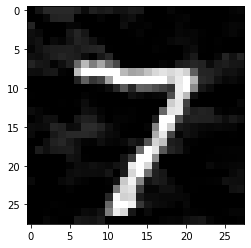

In [101]:
plt.imshow(mnist_adv_test_dataset[0][0].squeeze().detach().cpu().numpy(), cmap = "gray")

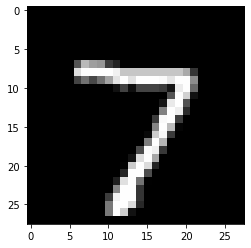

In [102]:
plt.imshow(mnist_test_dataset[0][0].squeeze().detach().cpu().numpy(), cmap = "gray")